In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import json
import re
from datetime import datetime
from string import punctuation
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import torch.nn as nn
%matplotlib inline

In [9]:
raw_data_file_path = "./ratebeer.json"

In [92]:
# initial pass at fixing data
f = open(raw_data_file_path)
s = f.read()
s = s.replace('"', "'")
s = s.replace("\\", "")
s = re.sub(r"'([a-zA-Z0-9\/]+)':( ')", r'"\1":\2', s)
s = re.sub(r": '(.*?)'(, \"|})", r': "\1"\2', s)
s = s.replace("}", "},")
s = "[" + s + "]"

In [93]:
# edge cases
index1 = 1211756778
sus = 5
s = s[0:index1-sus] + "'" + s[index1-sus+1:]
index2 = 1211757555
sus = 3
s = s[0:index2-sus] + '"' + s[index2-sus+1:]
index3 = 1931627431
sus = 2
s = s[0:index3-sus] + s[index3-sus+1:]

In [90]:
data = json.loads(s)

In [91]:
# save as new json file
json_object = json.dumps(data, indent=4)
with open("./beer_data.json", "w") as outfile:
    outfile.write(json_object)

In [401]:
data_file_path = './beer_data.json'
df_full = pd.read_json(data_file_path)

In [404]:
def eval_expr(expr):
    try:
        return eval(expr)
    except:
        return -1

In [405]:
df_full['appearance'] = df_full.apply(lambda row : eval_expr(row['review/appearance']), axis=1)
df_full['aroma'] = df_full.apply(lambda row : eval_expr(row['review/aroma']), axis=1)
df_full['palate'] = df_full.apply(lambda row : eval_expr(row['review/palate']), axis=1)
df_full['taste'] = df_full.apply(lambda row : eval_expr(row['review/taste']), axis=1)
df_full['overall'] = df_full.apply(lambda row : eval_expr(row['review/overall']), axis=1)

In [409]:
df_full = df_full[(df_full['overall'] >= 0) & (df_full['beer/ABV'] != '-')]

In [560]:
df_full = df_full.reset_index(drop=True)

In [410]:
beer_names = df_full['beer/name'].unique()
beer_styles = df_full['beer/style'].unique()
beer_style_index = dict(zip(beer_styles, range(len(beer_styles))))

In [411]:
df_full['abv'] = df_full.apply(lambda row: float(row['beer/ABV']), axis=1)
df_full['style'] = df_full.apply(lambda row: beer_style_index[row['beer/style']], axis=1)

/Users/maxyuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxyuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [561]:
positive_rating = df_full[df_full['overall'] > 0.5]
negative_rating = df_full[df_full['overall'] <= 0.5]

high_rating = df_full[df_full['overall'] > 0.7]
med_rating = df_full[(df_full['overall'] >= 0.4) & (df_full['overall'] <= 0.7)]
low_rating = df_full[df_full['overall'] < 0.4]

In [562]:
print(len(positive_rating.index))
print(len(negative_rating.index))

print(len(high_rating.index))
print(len(med_rating.index))
print(len(low_rating.index))

2299884
485642
1100450
1501568
183508


In [582]:
NUM_SAMPLES = 18000
NUM_SAMPELS_WITH_PADDING = NUM_SAMPLES + 300 # we remove empty removes later so this allows for that
positive_indices = random.sample(positive_rating.index.tolist(), int(NUM_SAMPELS_WITH_PADDING / 2))
negative_indices = random.sample(negative_rating.index.tolist(), int(NUM_SAMPELS_WITH_PADDING / 2))

high_indices = random.sample(high_rating.index.tolist(), int(NUM_SAMPELS_WITH_PADDING / 3))
med_indices = random.sample(med_rating.index.tolist(), int(NUM_SAMPELS_WITH_PADDING / 3))
low_indices = random.sample(low_rating.index.tolist(), int(NUM_SAMPELS_WITH_PADDING / 3))

In [583]:
rows_b = positive_indices + negative_indices
rows_t = high_indices + med_indices +low_indices

In [584]:
df_b = df_full.iloc[rows_b]
df_t = df_full.iloc[rows_t]

In [585]:
print(df_b.shape)
df_b.head()

(18300, 20)


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,appearance,aroma,palate,taste,overall,abv,style
1715141,Bells Oberon Ale,3211,232.0,6,Wheat Ale,5/5,7/10,4/5,8/10,15/20,1.038096e+09,Andrew196,Probably the best wheat beer I have had in a l...,1.0,0.7,0.8,0.8,0.75,6.0,21
672442,Ridgeway Foreign Export Stout,70803,1265.0,8,Foreign Stout,4/5,6/10,3/5,6/10,13/20,1.200874e+09,MesandSim,"UPDATED: AUG 28, 2008 A Mes rate: Bottle at my...",0.8,0.6,0.6,0.6,0.65,8.0,69
631026,Cigar City Extra Sour Guava Grove,136408,9990.0,8,Sour Ale/Wild Ale,3/5,7/10,3/5,8/10,15/20,1.324598e+09,sebletitje,Entering old rates. Bottle shared with Wayne @...,0.6,0.7,0.6,0.8,0.75,8.0,23
1537341,Victory Dark Intrigue,132106,101.0,9.1,Imperial Stout,4/5,7/10,4/5,7/10,15/20,1.303085e+09,Fin,"Bottle at Jan & Charlottes tasting, Ulfborg,...",0.8,0.7,0.8,0.7,0.75,9.1,13
1062334,Founders Double Trouble IPA,67360,554.0,9.4,Imperial/Double IPA,4/5,8/10,4/5,8/10,17/20,1.241309e+09,ApisAles,Really solid IPA. Had it on tap at RFD in D.C...,0.8,0.8,0.8,0.8,0.85,9.4,7


In [586]:
print(df_t.shape)
df_t.head()

(18300, 20)


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,appearance,aroma,palate,taste,overall,abv,style
1688104,Bells Java Stout,10338,232.0,7.5,Stout,4/5,9/10,5/5,8/10,15/20,1.214266e+09,lunchbox582,12 oz bought from the brewery in a mixed sixer...,0.8,0.9,1.0,0.8,0.75,7.5,16
330058,Pinkus Hefe Weizen,4552,742.0,5,German Hefeweizen,4/5,8/10,4/5,8/10,17/20,1.012349e+09,wheatbeerboy,A really different tasting hefeweizen. I could...,0.8,0.8,0.8,0.8,0.85,5.0,30
1792395,Leelanau Whaleback White,49308,4923.0,5.2,Belgian White &#40;Witbier&#41;,4/5,7/10,4/5,8/10,16/20,1.168992e+09,thebaldwizard,Shared at C-bus tasting 5. I wish all Wits ta...,0.8,0.7,0.8,0.8,0.80,5.2,36
1114182,Sierra Nevada Hoptimum,117825,67.0,10.4,Imperial/Double IPA,4/5,7/10,4/5,7/10,16/20,1.284422e+09,JohnnyJ,"Draft at the brewery. Golden amber pour, whit...",0.8,0.7,0.8,0.7,0.80,10.4,7
1008245,Samuel Adams Imperial Series Double Bock,96144,32.0,9.5,Doppelbock,3/5,7/10,3/5,7/10,16/20,1.236384e+09,emacgee,Pours a dark ruby copper with a thin light tan...,0.6,0.7,0.6,0.7,0.80,9.5,38


In [587]:
reviews_b = df_b['review/text'].values.tolist()
reviews_b = [review.translate(str.maketrans('','',punctuation)).lower() for review in reviews_b]

reviews_t = df_t['review/text'].values.tolist()
reviews_t = [review.translate(str.maketrans('','',punctuation)).lower() for review in reviews_t]

In [588]:
all_reviews_b = ' '.join(reviews_b)
words_b = all_reviews_b.split()
word_to_count_b = Counter(words_b)
words_sorted_b = word_to_count_b.most_common(len(words_b))
word_to_index_b = {word:index+1 for index, (word,count) in enumerate(words_sorted_b)}

all_reviews_t = ' '.join(reviews_t)
words_t = all_reviews_t.split()
word_to_count_t = Counter(words_t)
words_sorted_t = word_to_count_t.most_common(len(words_t))
word_to_index_t = {word:index+1 for index, (word,count) in enumerate(words_sorted_t)}

In [589]:
reviews_tokenized_og_b = [[word_to_index_b[word] for word in review.split()] for review in reviews_b]
reviews_tokenized_og_t = [[word_to_index_t[word] for word in review.split()] for review in reviews_t]

In [592]:
overall_ratings_b = df_b['overall'].values.tolist()
binary_labels_og = [1 if rating > 0.5 else 0 for rating in overall_ratings_b]

overall_ratings_t = df_t['overall'].values.tolist()
ternary_labels_og = [2 if rating > 0.7 else (0 if rating < 0.4 else 1) for rating in overall_ratings_t]

print([binary_labels_og.count(x) for x in range(2)])
print([ternary_labels_og.count(x) for x in range(3)])

[9150, 9150]
[6100, 6100, 6100]


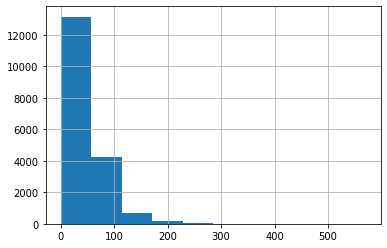

count    18300.000000
mean        49.345902
std         35.626908
min          0.000000
25%         27.000000
50%         40.000000
75%         60.000000
max        570.000000
dtype: float64

In [593]:
reviews_len_b = [len(x) for x in reviews_tokenized_og_b]
pd.Series(reviews_len_b).hist()
plt.show()
pd.Series(reviews_len_b).describe()

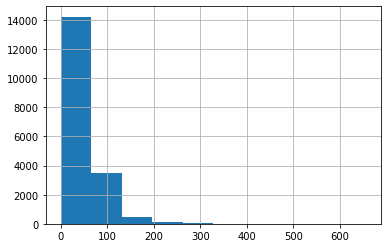

count    18300.000000
mean        50.530929
std         36.861034
min          0.000000
25%         28.000000
50%         41.000000
75%         62.000000
max        655.000000
dtype: float64

In [594]:
reviews_len_t = [len(x) for x in reviews_tokenized_og_t]
pd.Series(reviews_len_t).hist()
plt.show()
pd.Series(reviews_len_t).describe()

In [595]:
reviews_tokenized_og_b = [reviews_tokenized_og_b[i] for i, length in enumerate(reviews_len_b) if length > 0]
reviews_tokenized_og_t = [reviews_tokenized_og_t[i] for i, length in enumerate(reviews_len_t) if length > 0]

binary_labels_og = [binary_labels_og[i] for i, length in enumerate(reviews_len_b) if length > 0]
ternary_labels_og = [ternary_labels_og[i] for i, length in enumerate(reviews_len_t) if length > 0]

In [596]:
def pad_tokens(reviews, seq_length):
    # pad beginning of tokens with 0 or truncate to seq_length
    features = np.zeros((len(reviews), seq_length), dtype = int)
    
    for index, tokens in enumerate(reviews):
        if len(tokens) != 0:
            features[index, -(min(seq_length, len(tokens))):] = np.array(tokens)[:min(seq_lenth, len(tokens))]
    
    return features

In [601]:
features_og_b = pad_features(reviews_tokenized_og_b, 200)
features_og_t = pad_features(reviews_tokenized_og_t, 200)

binary_labels_og=np.array(binary_labels_og)
ternary_labels_og=np.array(ternary_labels_og)

In [603]:
num_features_og_b = len(features_og_b)
num_features_og_t = len(features_og_t)

random_subset_b = random.sample(range(num_features_og_b), NUM_SAMPLES)
random_subset_t = random.sample(range(num_features_og_t), NUM_SAMPLES)

features_b = features_og_b[random_subset_b,]
binary_labels = binary_labels_og[random_subset_b]

features_t = features_og_t[random_subset_t,]
ternary_labels = ternary_labels_og[random_subset_t]

print(features_b.shape)
print(features_t.shape)
print(binary_labels.shape)
print(ternary_labels.shape)

(18000, 200)
(18000, 200)
(18000,)
(18000,)


In [604]:
print(np.mean(binary_labels==random.choices(range(2), k=len(binary_labels))))
print(np.mean(ternary_labels==random.choices(range(3), k=len(ternary_labels))))

0.4976111111111111
0.3298333333333333


In [605]:
split_frac = 0.8
num_features = len(features)
train_x_b = features_b[0:int(split_frac*num_features)]
train_x_t = features_t[0:int(split_frac*num_features)]
train_y_b = binary_labels[0:int(split_frac*num_features)]
train_y_t = ternary_labels[0:int(split_frac*num_features)]

remaining_x_b = features_b[int(split_frac*num_features):]
remaining_x_t = features_t[int(split_frac*num_features):]
remaining_y_b = binary_labels[int(split_frac*num_features):]
remaining_y_t = ternary_labels[int(split_frac*num_features):]

valid_x_b = remaining_x_b[0:int(len(remaining_x_b)*0.5)]
valid_x_t = remaining_x_t[0:int(len(remaining_x_t)*0.5)]
valid_y_b = remaining_y_b[0:int(len(remaining_y_b)*0.5)]
valid_y_t = remaining_y_t[0:int(len(remaining_y_t)*0.5)]

test_x_b = remaining_x_b[int(len(remaining_x_b)*0.5):]
test_x_t = remaining_x_t[int(len(remaining_x_t)*0.5):]
test_y_b = remaining_y_b[int(len(remaining_y_b)*0.5):]
test_y_t = remaining_y_t[int(len(remaining_y_t)*0.5):]

In [606]:
class SentimentLSTM(nn.Module):
    # LSTM for sentiment analysis

    def __init__(
        self,
        vocab_size,
        output_size,
        embedding_dim,
        hidden_dim,
    ):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, 2, dropout=0.5, batch_first=True
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # fully connected linear layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        # sigmoid layer for the binary sentiment analysis case
        self.sig = nn.Sigmoid()
        
        # softmax layer for the ternary sentiment analysis case
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid or softmax function
        prob_out = self.sig(out) if self.output_size == 1 else self.softmax(out)

        # reshape to be batch_size as first dimension
        if self.output_size == 1:
            prob_out = prob_out.view(batch_size, -1)
            prob_out = prob_out[:, -1]  # get last batch of labels
        else:
            prob_out = prob_out.view(batch_size, -1, self.output_size)
            prob_out = prob_out[:, -1, :] # get last batch of labels
        

        # return last sigmoid/softmax output and hidden state
        return prob_out, hidden

    def init_hidden(self, batch_size):
        # create 2 tensors with sizes 2 x batch_size x hidden_dim,
        weight = next(self.parameters()).data

        # initialized hidden state to 0
        hidden = (
            weight.new(2, batch_size, self.hidden_dim).zero_(),
            weight.new(2, batch_size, self.hidden_dim).zero_(),
        )

        return hidden


In [607]:
batch_size = 50
# create Tensor datasets
train_data_b = TensorDataset(torch.from_numpy(train_x_b), torch.from_numpy(train_y_b))
valid_data_b = TensorDataset(torch.from_numpy(valid_x_b), torch.from_numpy(valid_y_b))
test_data_b = TensorDataset(torch.from_numpy(test_x_b), torch.from_numpy(test_y_b))

train_data_t = TensorDataset(torch.from_numpy(train_x_t), torch.from_numpy(train_y_t))
valid_data_t = TensorDataset(torch.from_numpy(valid_x_t), torch.from_numpy(valid_y_t))
test_data_t = TensorDataset(torch.from_numpy(test_x_t), torch.from_numpy(test_y_t))

# dataloaders

# make sure to SHUFFLE your data
train_loader_b = DataLoader(train_data_b, shuffle=True, batch_size=batch_size)
valid_loader_b = DataLoader(valid_data_b, shuffle=True, batch_size=batch_size)
test_loader_b = DataLoader(test_data_b, shuffle=True, batch_size=batch_size)

train_loader_t = DataLoader(train_data_t, shuffle=True, batch_size=batch_size)
valid_loader_t = DataLoader(valid_data_t, shuffle=True, batch_size=batch_size)
test_loader_t = DataLoader(test_data_t, shuffle=True, batch_size=batch_size)

In [608]:
# Create the two models
vocab_size_b = len(word_to_index_b)+1
vocab_size_t = len(word_to_index_t)+1
output_size_b = 1
output_size_t = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net_b = SentimentLSTM(vocab_size_b, output_size_b, embedding_dim, hidden_dim)
net_t = SentimentLSTM(vocab_size_t, output_size_t, embedding_dim, hidden_dim)
print(net_b)
print(net_t)

SentimentLSTM(
  (embedding): Embedding(36592, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
  (softmax): Softmax(dim=1)
)
SentimentLSTM(
  (embedding): Embedding(37244, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (sig): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [609]:
# TRAINING FOR BINARY SENTIMENT ANALYSIS

# loss and optimization functions
lr=1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net_b.parameters(), lr=lr)

# training params
epochs = 3
counter = 0
print_every = 50
clip=5 # gradient clipping
epoch_accuracies = []

net_b.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net_b.init_hidden(batch_size)
    
    epoch_correct = 0
    epoch_total = 0

    # batch loop
    for inputs, labels in train_loader_b:
        counter += 1
        # copy hidden state
        h = tuple([each.data for each in h])

        # zero gradients
        net_b.zero_grad()

        # get predicted output
        inputs = inputs.type(torch.LongTensor)
        output, h = net_b(inputs, h)
        
        # calculate accuracy for this step
        preds = torch.round(output.squeeze())
        mask = preds[preds == labels]
        train_correct = len(mask)
        train_total = len(labels)
        
        epoch_correct += train_correct
        epoch_total += train_total

        # calculate loss and backprop
        loss = loss_fn(output.squeeze(), labels.float())
        loss.backward()

        # prevent exploding gradient problem in LSTMs.
        nn.utils.clip_grad_norm_(net_b.parameters(), clip)
        optimizer.step()

        # print stats
        if counter % print_every == 0:
            val_h = net_b.init_hidden(batch_size)
            val_losses = []
            net_b.eval()
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader_b:
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net_b(inputs, val_h)
                
                preds = torch.round(output.squeeze())
                mask = preds[preds == labels]
                val_correct += len(mask)
                val_total += len(labels)
                
                val_loss = loss_fn(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

            net_b.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Accuracy: {:.6f}...".format(float(train_correct)/train_total),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Accuracy: {:.6f}...".format(float(val_correct) / val_total),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

    epoch_accuracies.append(float(epoch_correct) / epoch_total)

Epoch: 1/3... Step: 50... Accuracy: 0.700000... Loss: 0.584336... Val Accuracy: 0.695200... Val Loss: 0.577291
Epoch: 1/3... Step: 100... Accuracy: 0.780000... Loss: 0.523264... Val Accuracy: 0.738200... Val Loss: 0.564808
Epoch: 1/3... Step: 150... Accuracy: 0.640000... Loss: 0.595581... Val Accuracy: 0.658800... Val Loss: 0.605740
Epoch: 2/3... Step: 200... Accuracy: 0.780000... Loss: 0.519354... Val Accuracy: 0.727200... Val Loss: 0.543015
Epoch: 2/3... Step: 250... Accuracy: 0.780000... Loss: 0.413997... Val Accuracy: 0.752400... Val Loss: 0.516834
Epoch: 2/3... Step: 300... Accuracy: 0.760000... Loss: 0.458491... Val Accuracy: 0.749600... Val Loss: 0.512030
Epoch: 3/3... Step: 350... Accuracy: 0.960000... Loss: 0.225099... Val Accuracy: 0.775000... Val Loss: 0.490299
Epoch: 3/3... Step: 400... Accuracy: 0.840000... Loss: 0.416420... Val Accuracy: 0.747600... Val Loss: 0.523260
Epoch: 3/3... Step: 450... Accuracy: 0.880000... Loss: 0.285408... Val Accuracy: 0.779400... Val Loss: 0.

In [610]:
# test model
num_correct = 0

# init hidden state
h = net_b.init_hidden(batch_size)

net_b.eval()
# iterate over test data
for inputs, labels in test_loader_b:
    h = tuple([each.data for each in h])

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net_b(inputs, h)

    # get predicted class from output probabilities
    preds = torch.round(output.squeeze())
    mask = preds[preds == labels]
    num_correct += len(mask)

# test accuracy
print("Test accuracy: {:.3f}".format(float(num_correct)/len(test_loader_b.dataset)))

Test accuracy: 0.769


In [611]:
# TRAINING FOR TERNARY SENTIMENT ANALYSIS

# loss and optimization functions
lr=1e-3
# loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_t.parameters(), lr=lr)

# training params
epochs = 3
counter = 0
print_every = 50
clip=5 # gradient clipping
epoch_accuracies = []

net_t.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net_t.init_hidden(batch_size)
    
    epoch_correct = 0
    epoch_total = 0

    # batch loop
    for inputs, labels in train_loader_t:
        counter += 1
        # copy hidden state
        h = tuple([each.data for each in h])

        # zero gradients
        net_t.zero_grad()

        # get predicted output
        inputs = inputs.type(torch.LongTensor)
        output, h = net_t(inputs, h)
        preds = torch.argmax(output, dim=1)
        
        # calculate accuracy for this step
        preds = torch.argmax(output, dim=1)
        mask = preds[preds == labels]
        train_correct = len(mask)
        train_total = len(labels)
        
        epoch_correct += train_correct
        epoch_total += train_total

        # calculate loss and backprop
        loss = loss_fn(output, labels)
        loss.backward()

        # prevent exploding gradient problem in LSTMs.
        nn.utils.clip_grad_norm_(net_t.parameters(), clip)
        optimizer.step()

        # print stats
        if counter % print_every == 0:
            val_h = net_t.init_hidden(batch_size)
            val_losses = []
            net_t.eval()
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader_t:
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net_t(inputs, val_h)
                
                preds = torch.argmax(output, dim=1)
                mask = preds[preds == labels]
                val_correct += len(mask)
                val_total += len(labels)
                
                val_loss = loss_fn(output, labels)
                val_losses.append(val_loss.item())

            net_t.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Accuracy: {:.6f}...".format(float(train_correct)/train_total),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Accuracy: {:.6f}...".format(float(val_correct) / val_total),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

    epoch_accuracies.append(float(epoch_correct) / epoch_total)

Epoch: 1/3... Step: 50... Accuracy: 0.480000... Loss: 1.025306... Val Accuracy: 0.534000... Val Loss: 0.987844
Epoch: 1/3... Step: 100... Accuracy: 0.400000... Loss: 1.073568... Val Accuracy: 0.395200... Val Loss: 1.112575
Epoch: 1/3... Step: 150... Accuracy: 0.380000... Loss: 1.104991... Val Accuracy: 0.406000... Val Loss: 1.088468
Epoch: 2/3... Step: 200... Accuracy: 0.440000... Loss: 1.059408... Val Accuracy: 0.486200... Val Loss: 1.032503
Epoch: 2/3... Step: 250... Accuracy: 0.620000... Loss: 0.970256... Val Accuracy: 0.503400... Val Loss: 1.023751
Epoch: 2/3... Step: 300... Accuracy: 0.560000... Loss: 0.933551... Val Accuracy: 0.592400... Val Loss: 0.937244
Epoch: 3/3... Step: 350... Accuracy: 0.720000... Loss: 0.812704... Val Accuracy: 0.627000... Val Loss: 0.907556
Epoch: 3/3... Step: 400... Accuracy: 0.700000... Loss: 0.816624... Val Accuracy: 0.615200... Val Loss: 0.921896
Epoch: 3/3... Step: 450... Accuracy: 0.620000... Loss: 0.913079... Val Accuracy: 0.611600... Val Loss: 0.

In [616]:
for i in range(len(epoch_accuracies)):
    print("Epoch #{} Accuracy: {:.3f}%".format(i + 1, epoch_accuracies[i] * 100))

Epoch #1 Accuracy: 39.712%
Epoch #2 Accuracy: 53.312%
Epoch #3 Accuracy: 66.200%


In [612]:
# test model
num_correct = 0

# init hidden state
h = net_t.init_hidden(batch_size)

net_t.eval()
# iterate over test data
for inputs, labels in test_loader_t:
    h = tuple([each.data for each in h])

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net_t(inputs, h)

    # get predicted class from output probabilities
    preds = torch.argmax(output, dim=1)
    mask = preds[preds == labels]
    num_correct += len(mask)

# test accuracy
print("Test accuracy: {:.3f}".format(float(num_correct)/len(test_loader_b.dataset)))

Test accuracy: 0.647


In [395]:
abvs = df_full['abv'].values.tolist()
styles = df_full['style'].values.tolist()
ratings = df_full['overall'].values.tolist()
taste_ratings = df_full['taste'].values.tolist()
times = df_full['review/time'].values.tolist()
reviewers = df_full['review/profileName'].values.tolist()

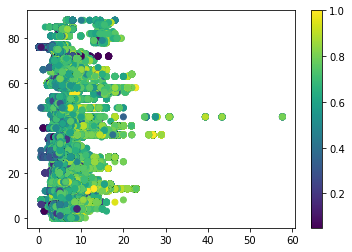

In [396]:
plt.scatter(abvs, styles, c=ratings)
plt.colorbar()

In [397]:
reviewers_unique = df_full['review/profileName'].unique()

In [398]:
min_times = {}
max_times = {}

for i in range(len(times)):
    name = reviewers[i]
    time = times[i]
    if not name in min_times:
        min_times[name] = time
    if not name in max_times:
        max_times[name] = time
    min_times[name] = min(time, min_times[name])
    max_times[name] = max(time, max_times[name])

In [399]:
experience = []
for i in range(len(times)):
    experience.append((times[i] - min_times[reviewers[i]]) / (60 * 60 * 24))

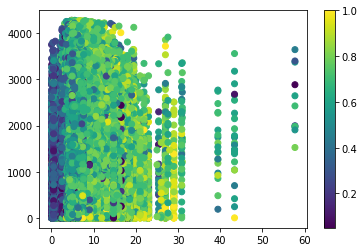

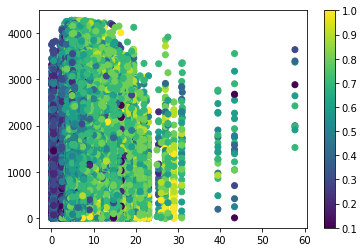

In [400]:
plt.scatter(abvs, experience, c=ratings)
plt.colorbar()
plt.show()

plt.scatter(abvs, experience, c=taste_ratings)
plt.colorbar()
plt.show()